In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Contour Matching

In [7]:
def preprocess_image(image):
    # Convert to grayscale and threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)

    # Find largest contour (the key)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    key_contour = max(contours, key=cv2.contourArea)

    # Fit a line to the contour (major axis)
    line_params = cv2.fitLine(key_contour, cv2.DIST_L2, 0, 0.01, 0.01)
    vx, vy, x0, y0 = line_params.flatten()  # Convert to 1D array and unpack

    # Compute endpoints of the major axis (for visualization)
    length = 1000
    x1 = int(x0 - vx * length)
    y1 = int(y0 - vy * length)
    x2 = int(x0 + vx * length)
    y2 = int(y0 + vy * length)

    # Calculate angle (0° = horizontal, 90° = vertical)
    angle = -np.degrees(np.arctan2(vy, vx)) % 180  # Normalized to [0, 180)

    # Center = midpoint of the major axis
    center = ((x1 + x2) // 2, (y1 + y2) // 2)

    # Visualization
    image = image.copy()
    cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.circle(image, center, 5, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    return binary, center, angle, key_contour

In [8]:
def align_image(src_image, src_center, src_angle, target_center, target_angle, value):
    # Compute minimal angle difference (accounts for 180° symmetry)
    angle_diff = (target_angle - src_angle + 90) % 180 - 90

    # Rotate around source center
    rot_mat = cv2.getRotationMatrix2D(src_center, angle_diff, 1.0)
    rotated = cv2.warpAffine(src_image, rot_mat, (src_image.shape[1], src_image.shape[0]), borderValue=value)

    # Compute new center after rotation (homogeneous coordinates)
    new_center = np.dot(rot_mat, np.array([*src_center, 1]))

    # Translate to match target center
    dx = target_center[0] - new_center[0]
    dy = target_center[1] - new_center[1]
    trans_mat = np.float32([[1, 0, dx], [0, 1, dy]])
    aligned = cv2.warpAffine(rotated, trans_mat, (rotated.shape[1], rotated.shape[0]), borderValue=value)

    return aligned

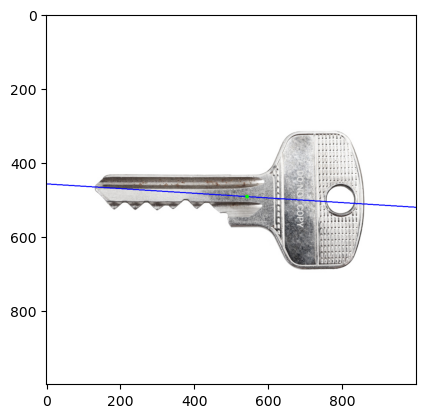

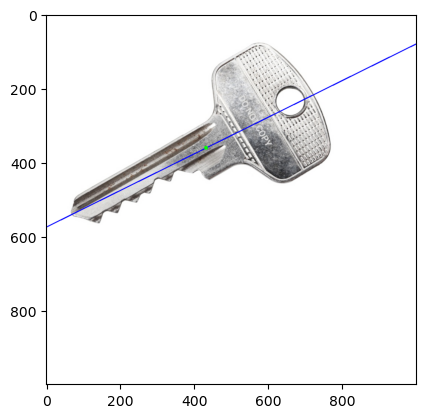

Similarity:0.011364170565136722


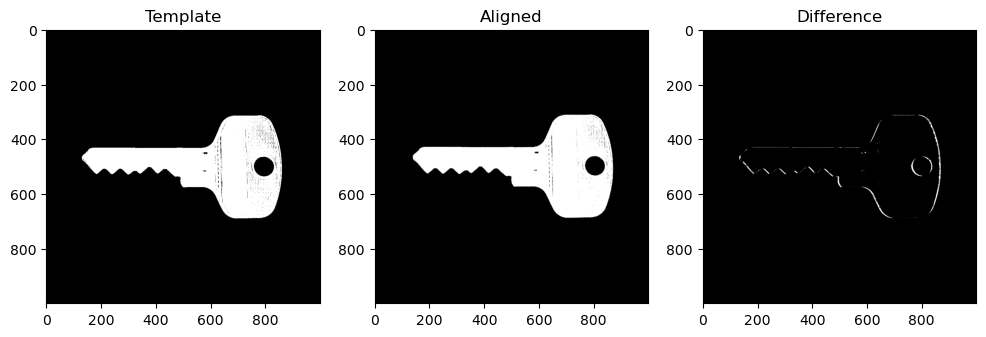

In [9]:
# Load images
template = cv2.imread('imagenes/key_template.png')
rotated = cv2.imread('imagenes/rotated.jpeg')

# Preprocess images
bin_template, c_template, ang_template, cont_template = preprocess_image(template)
bin_rotated, c_rotated, ang_rotated, cont_rotated = preprocess_image(rotated)

# Align rotated to template
aligned_bin = align_image(bin_rotated, c_rotated, ang_rotated, c_template, ang_template, 0)

# XOR to highlight differences
diff = cv2.bitwise_xor(bin_template, aligned_bin)
diff = cv2.erode(diff, np.ones((3, 3), dtype=np.uint8))

# Compute similarity
similarity = cv2.matchShapes(cont_template, cont_rotated, cv2.CONTOURS_MATCH_I1, 0.0)
print(f'Similarity:{similarity}')

# Display results
fig, axes = plt.subplots(1,3, figsize=(12, 6))
axes[0].imshow(bin_template, cmap='gray')
axes[0].set_title('Template')
axes[1].imshow(aligned_bin, cmap='gray')
axes[1].set_title('Aligned')
axes[2].imshow(diff, cmap='gray')
axes[2].set_title('Difference')
plt.show()

### Entender Hough Transform

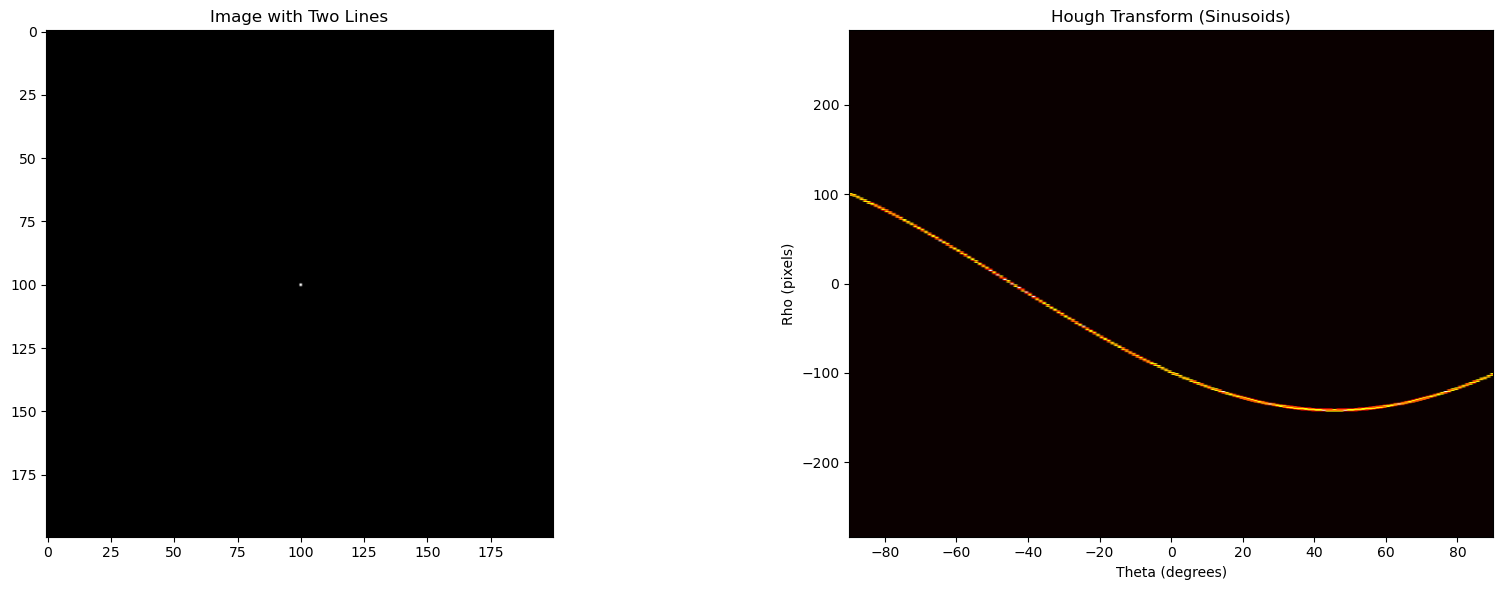

In [10]:
# Create a black image
img = np.zeros((200, 200), dtype=np.uint8)

img[100, 100] = 255
# cv2.line(img, (50, 150), (150, 50), 255, 2)   # Diagonal line (/)
# cv2.line(img, (50, 50), (150, 50), 255, 2)    # Horizontal line (-)

# Get coordinates of edge points
edges = cv2.Canny(img, 50, 150)
y_idxs, x_idxs = np.nonzero(edges)

# Hough Transform parameters
theta = np.deg2rad(np.arange(-90, 90))  # Angle range (-90° to 90°)
width, height = img.shape[1], img.shape[0]
diag_len = int(np.ceil(np.sqrt(width**2 + height**2)))  # max possible rho
rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

# Hough Accumulator (just to visualize sinusoids)
accumulator = np.zeros((len(rhos), len(theta)))

# Fill the accumulator (each edge point maps to a sinusoid in Hough space)
for x, y in zip(x_idxs, y_idxs):
    for t_idx in range(len(theta)):
        rho = x * np.cos(theta[t_idx]) + y * np.sin(theta[t_idx])
        rho_idx = int(rho + diag_len)
        accumulator[rho_idx, t_idx] += 1

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Original image
axs[0].imshow(img, cmap='gray')
axs[0].set_title("Image with Two Lines")

# Hough space (sinusoids)
axs[1].imshow(accumulator, cmap='hot', extent=[-90, 90, -diag_len, diag_len], aspect=0.25)
axs[1].set_title("Hough Transform (Sinusoids)")
axs[1].set_xlabel("Theta (degrees)")
axs[1].set_ylabel("Rho (pixels)")

plt.tight_layout()
plt.show()


### Entender Fourier Transform

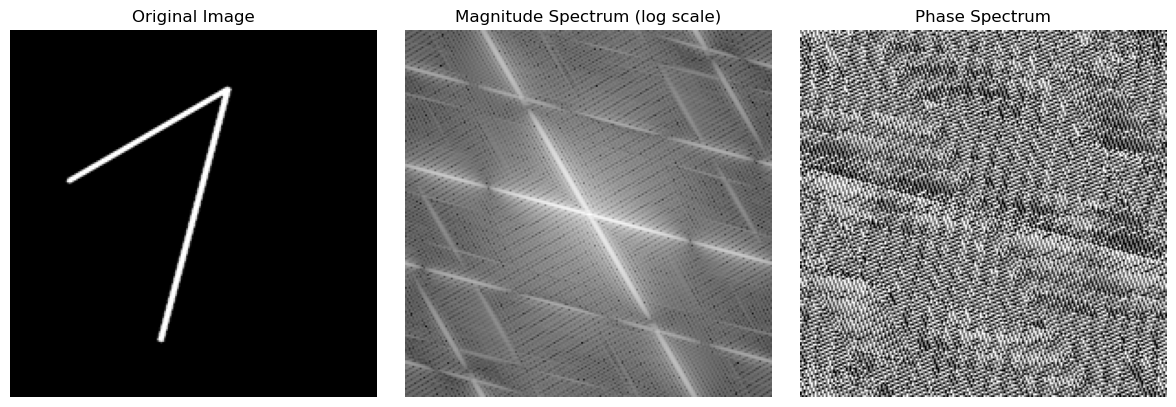

In [11]:
# Create a black image
img = np.zeros((200, 200), dtype=np.uint8)

cv2.line(img, (50, 150), (150, 50), 255, 2)   # Diagonal line (/)
cv2.line(img, (50, 50), (150, 50), 255, 2)    # Horizontal line (-)

# Rotate Image
rows, cols = img.shape[:2]
xc, yc = cols//2, rows//2
angle_rot = 30

rot_mat = cv2.getRotationMatrix2D((xc, yc), angle_rot, 1.0)
img = cv2.warpAffine(img, rot_mat, img.shape[:2][::-1], borderValue=0)

# Compute the 2D Discrete Fourier Transform (DFT)
dft = np.fft.fft2(img)  # Compute FFT
dft_shifted = np.fft.fftshift(dft)  # Shift zero-frequency to center

# Extract magnitude and phase
magnitude = np.abs(dft_shifted)  # Magnitude = sqrt(Re^2 + Im^2)
phase = np.angle(dft_shifted)    # Phase = arctan(Im / Re)

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(131), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.axis('off')

plt.subplot(132), plt.imshow(np.log1p(magnitude), cmap='gray')
plt.title('Magnitude Spectrum (log scale)'), plt.axis('off')

plt.subplot(133), plt.imshow(phase, cmap='gray')
plt.title('Phase Spectrum'), plt.axis('off')

plt.tight_layout()
plt.show()

#### Transformada inversa

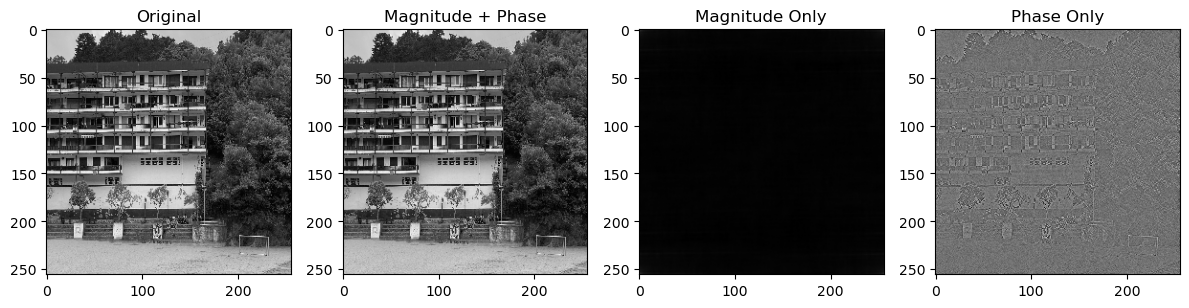

In [13]:
# Load image in grayscale
image = cv2.imread('imagenes/lines.jpeg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))  # Resize for simplicity

# Compute Fourier Transform and shift zero-frequency to center
dft = np.fft.fft2(image)
dft_shifted = np.fft.fftshift(dft)

# Extract magnitude and phase
magnitude = np.abs(dft_shifted)  # Magnitude = sqrt(Re² + Im²)
phase = np.angle(dft_shifted)    # Phase = arctan(Im / Re)

# Reconstruct image from magnitude and phase
reconstructed_complex = magnitude * np.exp(1j * phase)  # Combine magnitude and phase
reconstructed_dft = np.fft.ifftshift(reconstructed_complex)  # Undo the shift
reconstructed_image = np.fft.ifft2(reconstructed_dft)  # Inverse FT
reconstructed_image = np.abs(reconstructed_image)  # Take real part

# Reconstruct using ONLY magnitude (phase=0)
recon_magnitude_only = np.fft.ifft2(np.fft.ifftshift(magnitude)).real

# Reconstruct using ONLY phase (magnitude=1)
recon_phase_only = np.fft.ifft2(np.fft.ifftshift(np.exp(1j * phase))).real

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(141), plt.imshow(image, cmap='gray'), plt.title("Original")
plt.subplot(142), plt.imshow(reconstructed_image, cmap='gray'), plt.title("Magnitude + Phase")
plt.subplot(143), plt.imshow(recon_magnitude_only, cmap='gray'), plt.title("Magnitude Only")
plt.subplot(144), plt.imshow(recon_phase_only, cmap='gray'), plt.title("Phase Only")
plt.tight_layout()
plt.show()

#### Cambiar fases

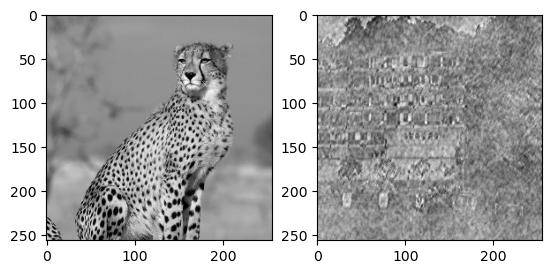

In [14]:
# Load and resize image 1
image1 = cv2.imread('imagenes/cheetah.jpg', cv2.IMREAD_GRAYSCALE)
image1 = cv2.resize(
    image1,
    dsize=(256, 256)
)

# Load and resize image 2
image2 = cv2.imread('imagenes/lines.jpeg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.resize(
    image2,
    dsize=(256, 256)
)

# Compute fourier transform
dft = np.fft.fft2(image1)
dft_image2 = np.fft.fft2(image2)

# Swap phase
image_phase_swapped = np.fft.ifft2(np.abs(dft) * np.exp(1j * np.angle(dft_image2))).real

fig, axes = plt.subplots(1, 2)
axes[0].imshow(image1, 'gray')
axes[1].imshow(image_phase_swapped, 'gray')
plt.show()


### Ejercicio
- Elimina altas frecuencias de la imagen y observa que ocurre
- Elimina bajas frecuencias de la imagen y observa que ocurre

In [15]:
# Load and prepare image
image = cv2.imread('imagenes/cheetah.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))

# Fourier Transform
dft = np.fft.fftshift(np.fft.fft2(image))
rows, cols = image.shape
crow, ccol = rows//2, cols//2

# Low-pass filter (keep low frequencies)
## DO SOMETHING HERE
dft_low = dft ...
img_low = np.abs(np.fft.ifft2(np.fft.ifftshift(dft_low)))

# High-pass filter (keep high frequencies)
## DO SOMETHING HERE
dft_high = dft ...
img_high = np.abs(np.fft.ifft2(np.fft.ifftshift(dft_high)))

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(131), plt.imshow(image, cmap='gray'), plt.title("Original")
plt.subplot(132), plt.imshow(img_low, cmap='gray'), plt.title("Low Frequencies")
plt.subplot(133), plt.imshow(img_high, cmap='gray'), plt.title("High Frequencies")
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (1411896939.py, line 12)

### Blurring (Gaussian Blur)

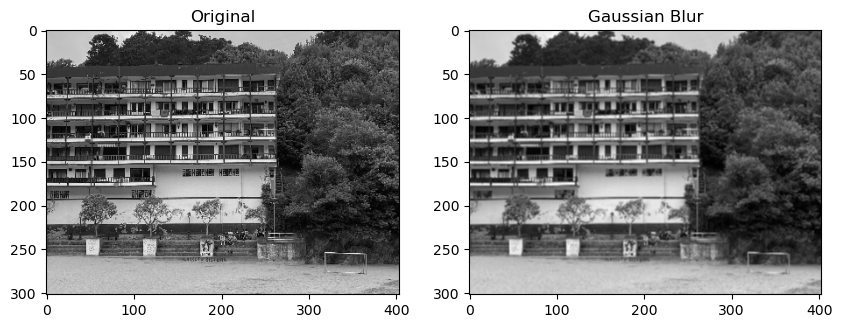

In [16]:
# Load image
image = cv2.imread('imagenes/lines.jpeg', cv2.IMREAD_GRAYSCALE)
downscale_factor = 0.1
image = cv2.resize(
    image,
    dsize=(
        int(image.shape[1]*downscale_factor),
        int(image.shape[0]*downscale_factor)
    )
)

# Define 3x3 Gaussian blur kernel
gaussian_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16  # Normalize to sum=1

# gaussian_kernel = np.array([
#     [1,  4,  6,  4, 1],
#     [4, 16, 24, 16, 4],
#     [6, 24, 36, 24, 6],
#     [4, 16, 24, 16, 4],
#     [1,  4,  6,  4, 1]
# ]) / 256

# Apply convolution
blurred = cv2.filter2D(image, -1, gaussian_kernel)
# blurred = cv2.filter2D(image, -1, gaussian_kernel, borderType=cv2.BORDER_REFLECT)

# Opencv alternative
# blurred = cv2.GaussianBlur(image, (11, 11), sigmaX=1)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(blurred, cmap='gray'), plt.title('Gaussian Blur')
plt.show()

### Edge Detection (Sobel Operator)

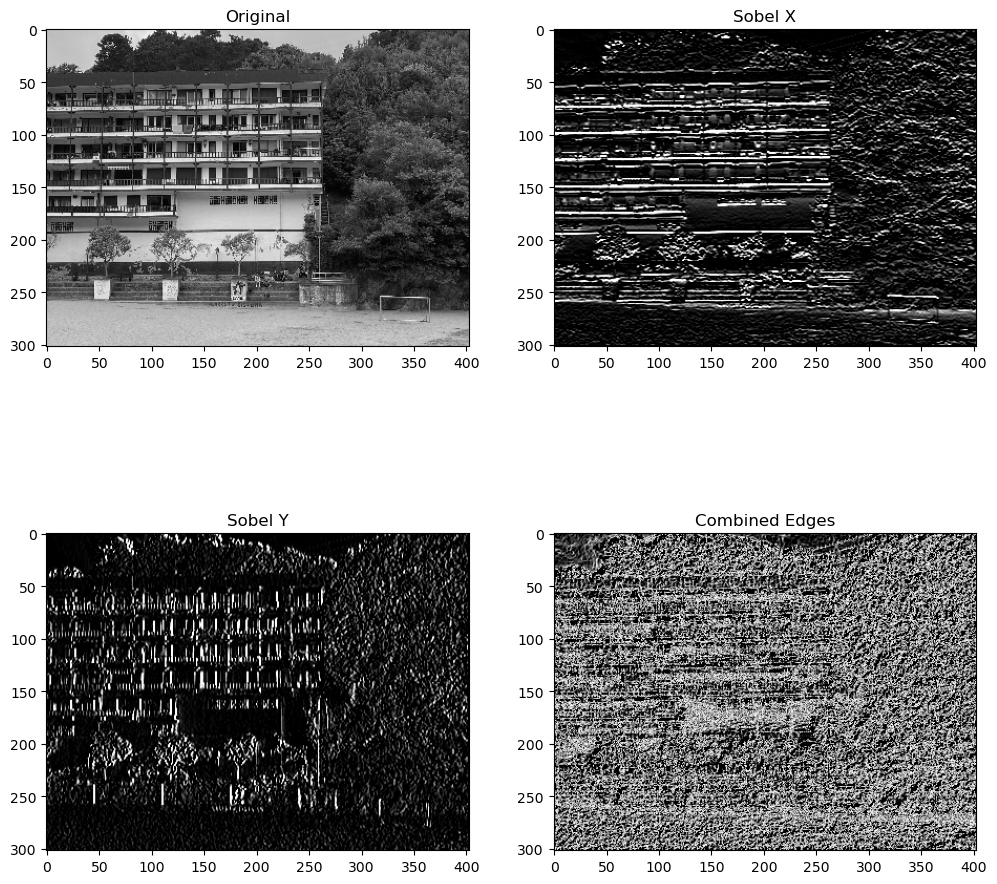

In [17]:
image = cv2.imread('imagenes/lines.jpeg', cv2.IMREAD_GRAYSCALE)
downscale_factor = 0.1
image = cv2.resize(
    image,
    dsize=(
        int(image.shape[1]*downscale_factor),
        int(image.shape[0]*downscale_factor)
    )
)

# Define Sobel kernels
sobel_x = np.array([  # Detects horizontal edges
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

sobel_y = np.array([  # Detects vertical edges
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

# Apply convolutions
edges_x = cv2.filter2D(image, -1, sobel_x)
edges_y = cv2.filter2D(image, -1, sobel_y)
edges_combined = np.sqrt(edges_x**2 + edges_y**2)  # Magnitude of gradient

# Plot
plt.figure(figsize=(12, 12))
plt.subplot(221), plt.imshow(image, cmap='gray'), plt.title('Original')
plt.subplot(222), plt.imshow(edges_x, cmap='gray'), plt.title('Sobel X')
plt.subplot(223), plt.imshow(edges_y, cmap='gray'), plt.title('Sobel Y')
plt.subplot(224), plt.imshow(edges_combined, cmap='gray'), plt.title('Combined Edges')
plt.show()

### Encontrar lineas en la imagen

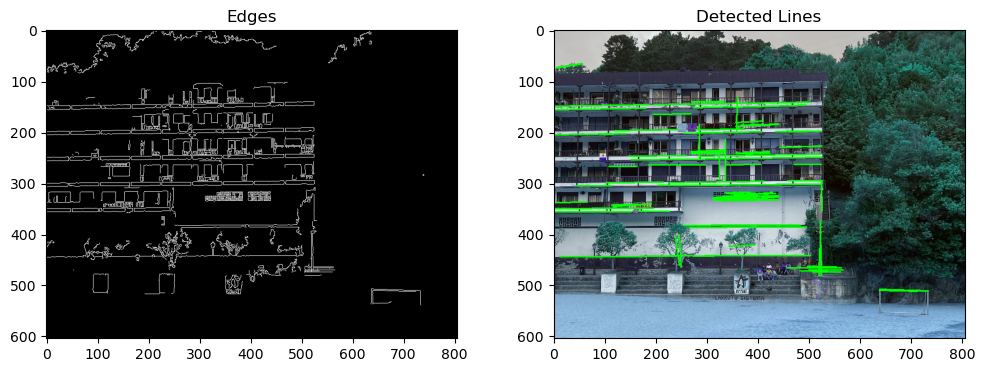

In [18]:
import cv2
import numpy as np

image = cv2.imread('imagenes/lines.jpeg')
downscale_factor = 0.2
image = cv2.resize(
    image,
    dsize=(
        int(image.shape[1]*downscale_factor),
        int(image.shape[0]*downscale_factor)
    )
)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Blur image
image_gray = cv2.GaussianBlur(image_gray, (11, 11), sigmaX=0.5)

# Edge detection (Canny)
edges = cv2.Canny(image_gray, 200, 600, apertureSize=3)

# Hough Line Transform (Probabilistic Hough)
lines = cv2.HoughLinesP(
    edges,            # Edge image
    rho=1,            # Distance resolution (pixels)
    theta=np.pi/180,  # Angle resolution (radians)
    threshold=50,     # Min. votes to detect a line
    minLineLength=50, # Min. line length (pixels)
    maxLineGap=10     # Max. allowed gap between line segments
)

# Draw detected lines on the original image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines, thickness=2

# Display results
plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(edges, 'gray'), plt.title('Edges')
plt.subplot(122), plt.imshow(image), plt.title('Detected Lines')
plt.show()

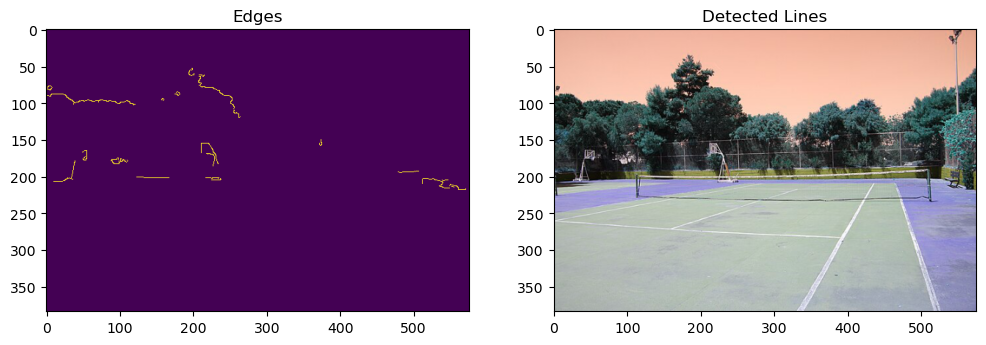

In [19]:
import cv2
import numpy as np

image = cv2.imread('imagenes/tennis_court.jpg')
downscale_factor = 0.9
image = cv2.resize(
    image,
    dsize=(
        int(image.shape[1]*downscale_factor),
        int(image.shape[0]*downscale_factor)
    )
)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur image
image_gray = cv2.GaussianBlur(image_gray, (3, 3), sigmaX=0.8)

# Edge detection (Canny)
edges = cv2.Canny(image_gray, 300, 600, apertureSize=3)

# Hough Line Transform (Probabilistic Hough)
lines = cv2.HoughLinesP(
    edges,            # Edge image
    rho=1,            # Distance resolution (pixels)
    theta=np.pi/180,  # Angle resolution (radians)
    threshold=50,     # Min. votes to detect a line
    minLineLength=50, # Min. line length (pixels)
    maxLineGap=10     # Max. allowed gap between line segments
)

# Draw detected lines on the original image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines, thickness=2

# Display results
plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(edges), plt.title('Edges')
plt.subplot(122), plt.imshow(image), plt.title('Detected Lines')
plt.show()

### Ejercicio: Encontrar la caja en la imagen

In [20]:
import cv2
import numpy as np

# Load image
image = cv2.imread('imagenes/coins_and_box.jpeg')  # Replace with your image
downscale_factor = 0.2
image = cv2.resize(
    image,
    dsize=(
        int(image.shape[1]*downscale_factor),
        int(image.shape[0]*downscale_factor)
    )
)

### Ejercicio: Nivel de liquido en botella

In [21]:
import cv2
import numpy as np

# Load image
image = cv2.imread('imagenes/bottle.jpg')  # Replace with your image
downscale_factor = 0.2
image = cv2.resize(
    image,
    dsize=(
        int(image.shape[1]*downscale_factor),
        int(image.shape[0]*downscale_factor)
    )
)


### Hough Circles

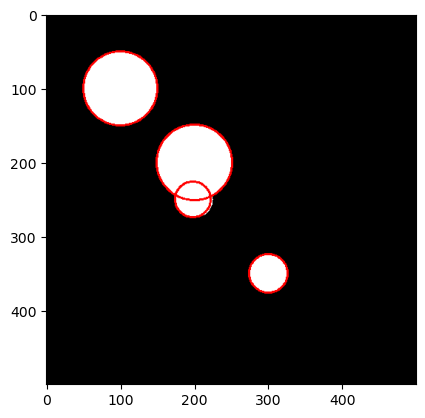

In [22]:
image = np.zeros((500, 500), dtype=np.uint8)
cv2.circle(image, (100, 100), 50, 255, -1)
cv2.circle(image, (200, 200), 50, 255, -1)
cv2.circle(image, (300, 350), 25, 255, -1)
cv2.circle(image, (200, 250), 25, 255, -1)
image_rgb = np.repeat(image[:, :, None], 3, axis=2)

circles = cv2.HoughCircles(
    image,
    cv2.HOUGH_GRADIENT,
    dp=1,            # Inverse ratio of accumulator resolution
    minDist=30,      # Minimum distance between detected centers
    param1=100,      # Upper threshold for Canny edge detector
    param2=10,       # Threshold for center detection (lower = more false circles)
    minRadius=1,     # Minimum radius
    maxRadius=100    # Maximum radius
) # returns [[[xc1, yx1, rc1]]] (float)

# Draw circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]

        # Draw the outer circle
        cv2.circle(image_rgb, center, radius, (255, 0 ,0), 2)

plt.imshow(image_rgb)
plt.show()

### Ejercicio: Encuentra las monedas

In [23]:
# Load image and downscale
image = cv2.imread('imagenes/coins_and_box.jpeg')  # Replace with your image
downscale_factor = 0.2
image = cv2.resize(
    image,
    dsize=(
        int(image.shape[1]*downscale_factor),
        int(image.shape[0]*downscale_factor)
    )
)
